# Load File


In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

# Start


In [2]:
import torch
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class PairDataset(Dataset):
    def __init__(self, csv_file, transform=None, cache=False):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.cache = cache
        self.cache_dict = {}

    def        __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # If cached, load from RAM
        if self.cache and idx in self.cache_dict:
            img1, img2 = self.cache_dict[idx]
        else:
            row = self.df.iloc[idx]
            img1_path = row["image1"]
            img2_path = row["image2"]

            with Image.open(img1_path) as im1:
                img1 = im1.convert("RGB").copy()
            with Image.open(img2_path) as im2:
                img2 = im2.convert("RGB").copy()

            if self.cache:
                self.cache_dict[idx] = (img1, img2)

        label = torch.tensor(self.df.iloc[idx]["label"], dtype=torch.long)

        # Apply transforms
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label



# 📌 2. Cosine Evaluation Function (Used for ALL Baselines)


In [3]:
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve

def evaluate_cosine_full(model, dataloader, device):
    model.eval()
    all_scores, all_labels = [], []

    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)

            labels = labels.cpu().numpy()

            emb1 = model(img1)
            emb2 = model(img2)

            cos = F.cosine_similarity(emb1, emb2, dim=1).cpu().numpy()

            all_scores.extend(list(cos))
            all_labels.extend(list(labels))

    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)

    # ------------------------------------------------------
    # 🔥 Best Threshold (sweeping)
    # ------------------------------------------------------
    best_acc = 0
    best_t = 0

    for t in np.linspace(-1, 1, 400):
        preds = (all_scores < t).astype(int)   # morph = 1
        acc = (preds == all_labels).mean()
        if acc > best_acc:
            best_acc = acc
            best_t = t

    # Apply the best threshold
    preds = (all_scores < best_t).astype(int)

    # ------------------------------------------------------
    # 🔥 Metrics
    # ------------------------------------------------------
    precision = precision_score(all_labels, preds, zero_division=0)
    recall = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    roc_auc = roc_auc_score(all_labels, 1- all_scores)

    # ------------------------------------------------------
    # 🔥 FAR / FRR / EER
    # ------------------------------------------------------
    fpr, tpr, thresholds = roc_curve(all_labels, -all_scores)  # invert for morph=1
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = (fpr[eer_index] + fnr[eer_index]) / 2

    FAR = fpr[eer_index]
    FRR = fnr[eer_index]

    # ------------------------------------------------------
    # 🔥 Avg Cosines
    # ------------------------------------------------------
    bona_cos = all_scores[all_labels == 0].mean()
    morph_cos = all_scores[all_labels == 1].mean()

    # ------------------------------------------------------
    # 🔥 Print Final Results (same format as your FYP model)
    # ------------------------------------------------------
    print("\n==================== COSINE BASELINE RESULTS ====================")
    print(f"Best Threshold:          {best_t:.4f}")
    print(f"Accuracy:                {best_acc * 100:.2f}%")
    print(f"Precision:               {precision:.4f}")
    print(f"Recall:                  {recall:.4f}")
    print(f"F1-Score:                {f1:.4f}")
    print(f"ROC-AUC:                 {roc_auc:.4f}")
    print(f"FAR:                     {FAR:.4f}")
    print(f"FRR:                     {FRR:.4f}")
    print(f"EER:                     {eer:.4f}")
    print(f"Avg Bona Cosine:         {bona_cos:.4f}")
    print(f"Avg Morph Cosine:        {morph_cos:.4f}")
    print("===============================================================\n")

    return {
        "threshold": best_t,
        "accuracy": best_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "far": FAR,
        "frr": FRR,
        "eer": eer,
        "bona_cos": bona_cos,
        "morph_cos": morph_cos,
        "all_scores": all_scores,
        "all_labels": all_labels
    }


# BASELINE 1: SIMPLE SIAMESE
1. Define a Simple Siamese Model

In [4]:
import torch.nn as nn
import torch

class SimpleSiamese(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.fc = nn.Linear(64, 128)

    def forward_once(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

    def forward(self, img1, img2):
        emb1 = self.forward_once(img1)
        emb2 = self.forward_once(img2)
        return emb1, emb2


2. Contrastive Loss

In [5]:
def contrastive_loss(emb1, emb2, label, margin=1.0):
    dist = F.pairwise_distance(emb1, emb2)
    loss = (1 - label) * dist.pow(2) + label * F.relu(margin - dist).pow(2)
    return loss.mean()


3. Train Siamese on FEI

In [6]:
import torch
import torch.nn.functional as F

def train_siamese(
    model,
    train_loader,
    val_loader,
    device,
    epochs=5,
    margin=1.0
):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        # =====================
        # TRAIN
        # =====================
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        for img1, img2, labels in train_loader:
            img1, img2 = img1.to(device), img2.to(device)
            labels = labels.float().to(device)

            emb1, emb2 = model(img1, img2)

            dist = F.pairwise_distance(emb1, emb2)
            loss = (1 - labels) * dist.pow(2) + labels * F.relu(margin - dist).pow(2)
            loss = loss.mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            preds = (dist > margin / 2).float()
            total_correct += (preds == labels).sum().item()

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples * 100

        # =====================
        # VALIDATION
        # =====================
        model.eval()
        val_correct, val_samples = 0, 0

        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2 = img1.to(device), img2.to(device)
                labels = labels.float().to(device)

                emb1, emb2 = model(img1, img2)
                dist = F.pairwise_distance(emb1, emb2)

                preds = (dist > margin / 2).float()
                val_correct += (preds == labels).sum().item()
                val_samples += labels.size(0)

        val_acc = val_correct / val_samples * 100

        # =====================
        # SAVE BEST
        # =====================
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Acc: {train_acc:.2f}% | "
            f"Val Acc: {val_acc:.2f}%"
        )

    # Load best model
    if best_state is not None:
        model.load_state_dict(best_state)

    print(f"Best Val Acc: {best_val_acc:.2f}%")
    return model


4. Testing Siamese Using Cosine (FRLL)

In [7]:
import torch.nn as nn

class SiameseEmbeddingWrapper(nn.Module):
    def __init__(self, siamese_model):
        super().__init__()
        self.siamese = siamese_model

    def forward(self, x):
        # x = batch of images
        # we only want the embedding for one branch
        return self.siamese.forward_once(x)


# BASELINE 2: ARCFACE + COSINE

In [8]:
!pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 98.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 104.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 87.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 35.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 15.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [9]:
from facenet_pytorch import InceptionResnetV1
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create FaceNet embedder
class FaceNetEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

    def forward(self, x):
        x = x.to(device)
        return self.model(x)


# BASELINE 3: FACENET + COSINE

In [10]:
from facenet_pytorch import InceptionResnetV1

facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

class FaceNetEmbedder(nn.Module):
    def forward(self, x):
        return facenet(x)


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [11]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),      # fixed size = no more mismatch
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

from torchvision import transforms
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),    # must match training
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [13]:
from torch.utils.data import DataLoader, ConcatDataset

# ============================
# FEI
# ============================
fei_train_dataset = PairDataset(
    csv_file="/kaggle/input/outputv2/FEI_train.csv",
    transform=train_transform,
    cache=True
)

fei_val_dataset = PairDataset(
    csv_file="/kaggle/input/outputv2/FEI_val.csv",
    transform=test_transform,
    cache=True
)

fei_test_dataset = PairDataset(
    csv_file="/kaggle/input/outputv2/FEI_test.csv",
    transform=test_transform,
    cache=True
)


# ============================
# FRLL
# ============================
frll_train_dataset = PairDataset(
    csv_file="/kaggle/input/outputv2/FRLL_train.csv",
    transform=train_transform,
    cache=True
)

frll_val_dataset = PairDataset(
    csv_file="/kaggle/input/outputv2/FRLL_val.csv",
    transform=test_transform,
    cache=True
)

frll_test_dataset = PairDataset(
    csv_file="/kaggle/input/outputv2/FRLL_test.csv",
    transform=test_transform,
    cache=True
)


In [14]:
mixed_train_dataset = ConcatDataset([
    fei_train_dataset,
    frll_train_dataset
])

mixed_val_dataset = ConcatDataset([
    fei_val_dataset,
    frll_val_dataset
])



In [15]:
mixed_train_loader = DataLoader(
    mixed_train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

mixed_val_loader = DataLoader(
    mixed_val_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

fei_test_loader = DataLoader(
    fei_test_dataset,
    batch_size=16,
    shuffle=False
)

frll_test_loader = DataLoader(
    frll_test_dataset,
    batch_size=16,
    shuffle=False
)


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(all_labels, all_scores, threshold, title):
    preds = (all_scores < threshold).astype(int)  # morph = 1

    cm = confusion_matrix(all_labels, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Bona Fide", "Morph"],
        yticklabels=["Bona Fide", "Morph"]
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(all_labels, all_cos, title):
    """
    all_labels: ground truth (0 = bonafide, 1 = morph)
    all_cos: cosine similarity (high = bonafide, low = morph)
    """

    # ✅ Invert cosine so that higher score = more likely morph
    scores = -all_cos

    fpr, tpr, thresholds = roc_curve(all_labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')   # random baseline
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_embedding_distance_distribution(model, dataloader, device,title):
    model.eval()
    distances = []
    labels = []

    with torch.no_grad():
        for img1, img2, lbl in dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)

            emb1 = model(img1)
            emb2 = model(img2)

            # 🔥 L2 distance between embeddings
            dist = torch.norm(emb1 - emb2, dim=1)

            distances.extend(dist.cpu().numpy())
            labels.extend(lbl.cpu().numpy())

    distances = np.array(distances)
    labels = np.array(labels)

    bona_dist = distances[labels == 0]
    morph_dist = distances[labels == 1]

    plt.figure(figsize=(7,5))
    plt.hist(bona_dist, bins=40, alpha=0.7, label="Bona-fide", color="blue")
    plt.hist(morph_dist, bins=40, alpha=0.7, label="Morph", color="red")

    plt.xlabel("Embedding Distance (L2)")
    plt.ylabel("Frequency")
    plt.title("Embedding Distance Distribution")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [19]:
simple_siamese = SimpleSiamese()

simple_siamese = train_siamese(
    model=simple_siamese,
    train_loader=mixed_train_loader,
    val_loader=mixed_val_loader,
    device=device,
    epochs=5,
    margin=1.0
)


Epoch 1/5 | Train Loss: 0.3115 | Train Acc: 49.34% | Val Acc: 51.51%
Epoch 2/5 | Train Loss: 0.2704 | Train Acc: 55.23% | Val Acc: 51.10%
Epoch 3/5 | Train Loss: 0.2635 | Train Acc: 56.03% | Val Acc: 50.84%
Epoch 4/5 | Train Loss: 0.2593 | Train Acc: 56.55% | Val Acc: 50.81%
Epoch 5/5 | Train Loss: 0.2646 | Train Acc: 55.08% | Val Acc: 50.84%
Best Val Acc: 51.51%


In [20]:
def evaluate_and_plot(
    embed_model,
    dataloader,
    device,
    model_name,
    dataset_name
):
    # ---------- Evaluate ----------
    result = evaluate_cosine_full(embed_model, dataloader, device)

    all_labels = result["all_labels"]
    all_scores = result["all_scores"]
    best_t     = result["threshold"]

    # ---------- Plots ----------
    plot_confusion_matrix(
        all_labels,
        all_scores,
        best_t,
        title=f"{model_name} — Confusion Matrix ({dataset_name})"
    )

    plot_roc_curve(
        all_labels,
        all_scores,
        title=f"{model_name} — ROC Curve ({dataset_name})"
    )

    plot_embedding_distance_distribution(
        embed_model,
        dataloader,
        device,
        title=f"{model_name} — Embedding Distance Distribution ({dataset_name})"
    )



==================== COSINE BASELINE RESULTS ====================
Best Threshold:          0.9699
Accuracy:                99.48%
Precision:               0.9968
Recall:                  0.9946
F1-Score:                0.9957
ROC-AUC:                 0.9997
FAR:                     0.0049
FRR:                     0.0043
EER:                     0.0046
Avg Bona Cosine:         0.9957
Avg Morph Cosine:        0.9051



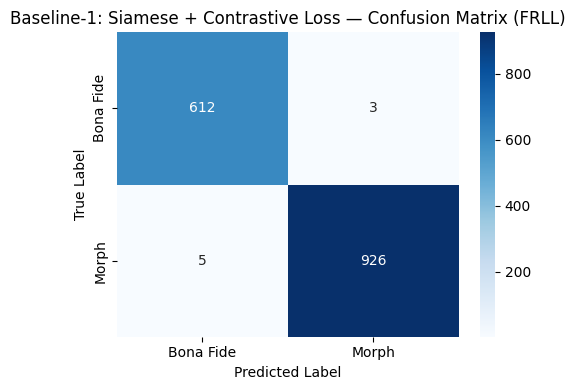

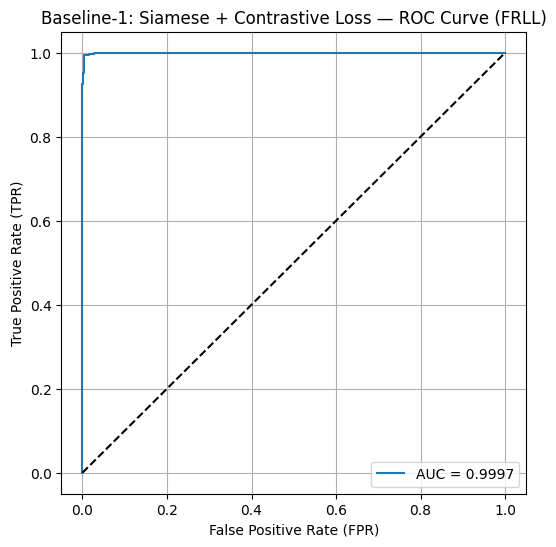

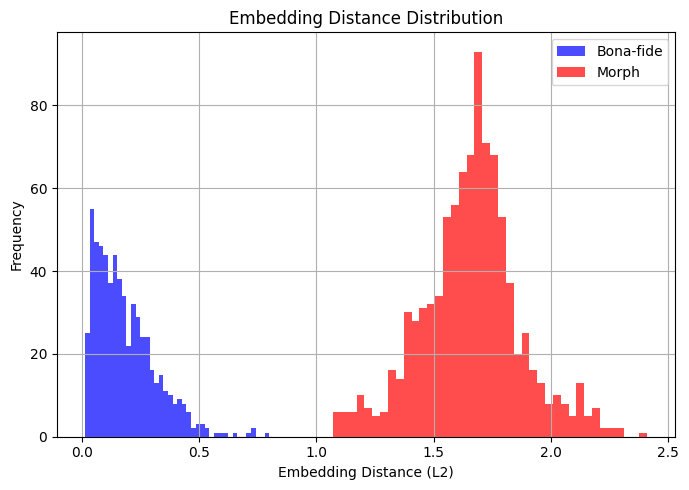

In [21]:
MODEL_NAME = "Baseline-1: Siamese + Contrastive Loss"

embed_simple = SiameseEmbeddingWrapper(simple_siamese)

evaluate_and_plot(
    embed_model=embed_simple,
    dataloader=frll_test_loader,
    device=device,
    model_name=MODEL_NAME,
    dataset_name = "FRLL"
)


==================== COSINE BASELINE RESULTS ====================
Best Threshold:          1.0000
Accuracy:                58.78%
Precision:               0.5878
Recall:                  1.0000
F1-Score:                0.7404
ROC-AUC:                 0.2934
FAR:                     0.6387
FRR:                     0.6389
EER:                     0.6388
Avg Bona Cosine:         0.9943
Avg Morph Cosine:        0.9989



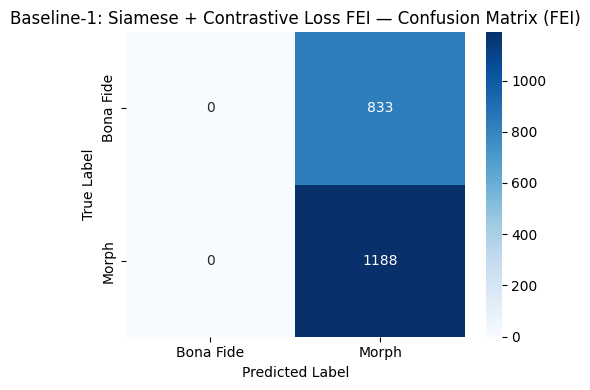

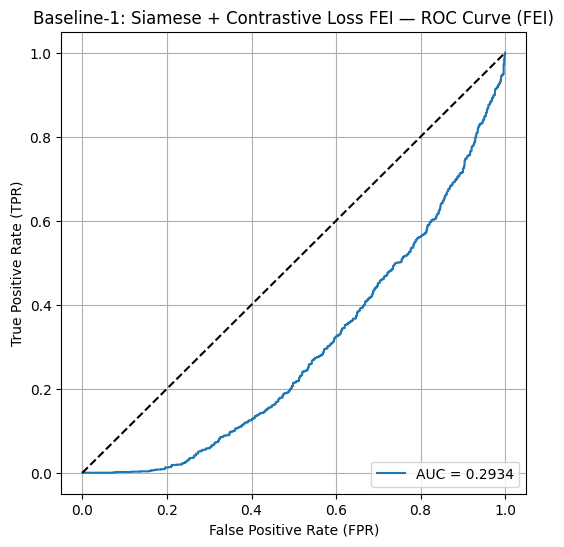

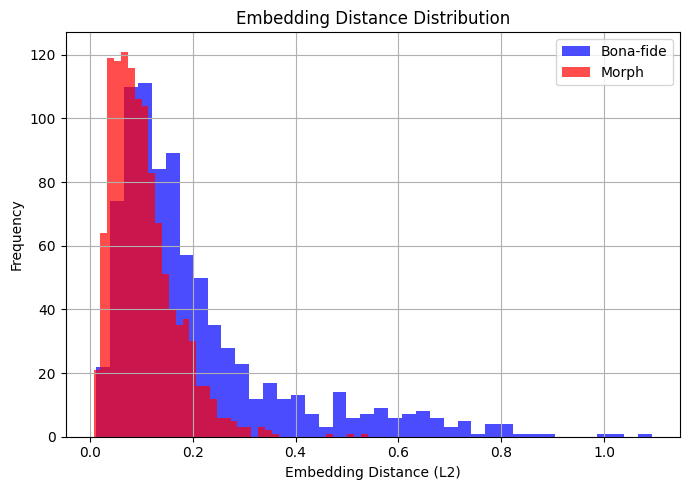

In [22]:
MODEL_NAME = "Baseline-1: Siamese + Contrastive Loss FEI"

embed_simple = SiameseEmbeddingWrapper(simple_siamese)

evaluate_and_plot(
    embed_model=embed_simple,
    dataloader=fei_test_loader,
    device=device,
    model_name=MODEL_NAME,
    dataset_name = "FEI"
)


==================== COSINE BASELINE RESULTS ====================
Best Threshold:          0.8045
Accuracy:                83.31%
Precision:               0.8056
Recall:                  0.9527
F1-Score:                0.8730
ROC-AUC:                 0.8937
FAR:                     0.1951
FRR:                     0.1933
EER:                     0.1942
Avg Bona Cosine:         0.8256
Avg Morph Cosine:        0.6614



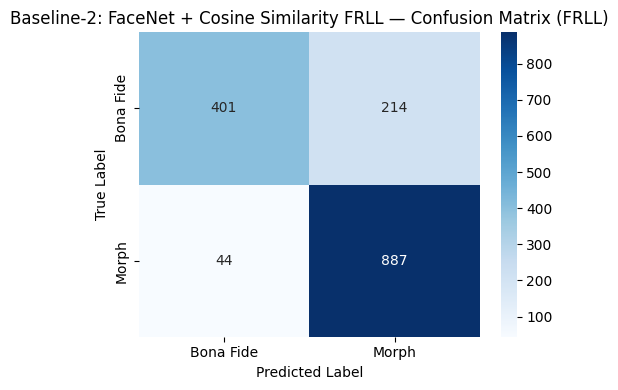

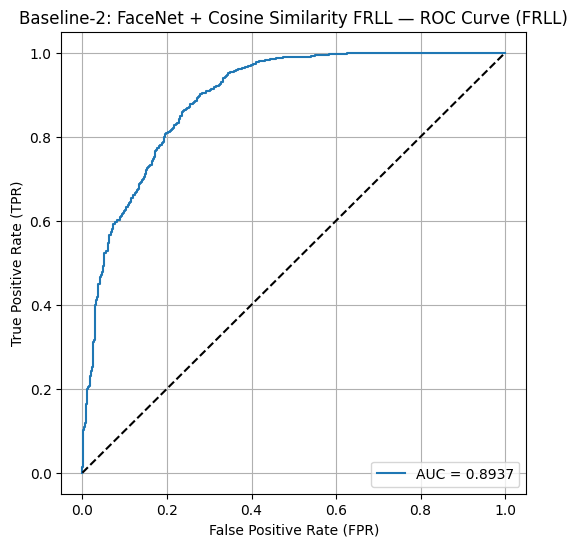

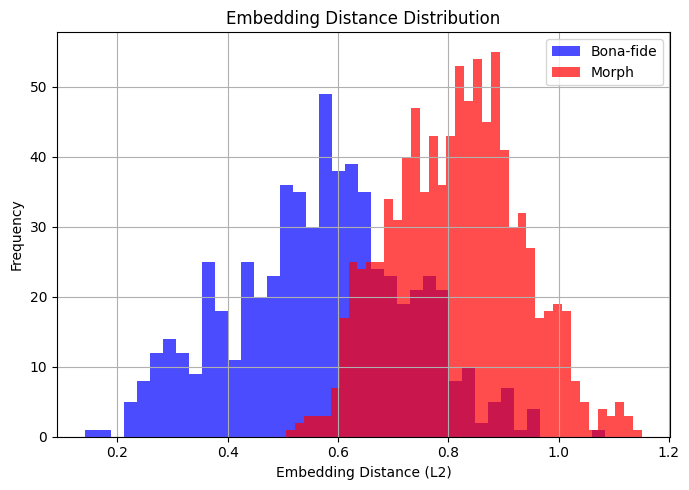

In [23]:
MODEL_NAME = "Baseline-2: FaceNet + Cosine Similarity FRLL"

facenet_model = FaceNetEmbedder().to(device)

evaluate_and_plot(
    embed_model=facenet_model,
    dataloader=frll_test_loader,
    device=device,
    model_name=MODEL_NAME,
    dataset_name = "FRLL"
)



==================== COSINE BASELINE RESULTS ====================
Best Threshold:          0.9699
Accuracy:                59.33%
Precision:               0.5926
Recall:                  0.9857
F1-Score:                0.7402
ROC-AUC:                 0.4524
FAR:                     0.5294
FRR:                     0.5303
EER:                     0.5299
Avg Bona Cosine:         0.8715
Avg Morph Cosine:        0.8939



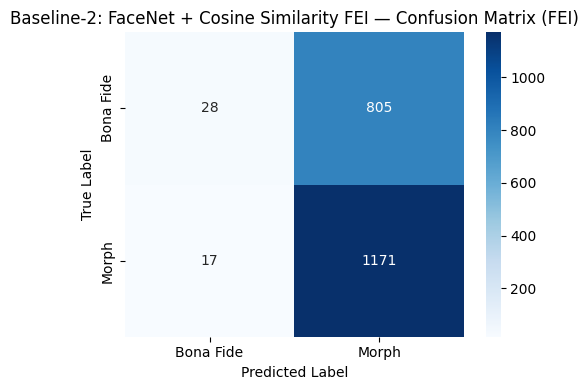

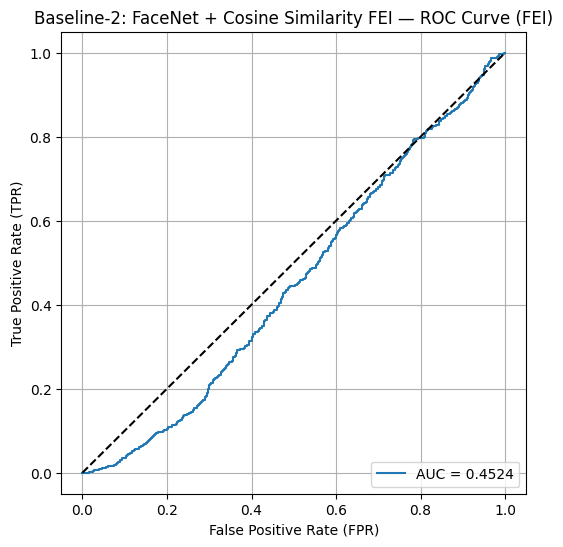

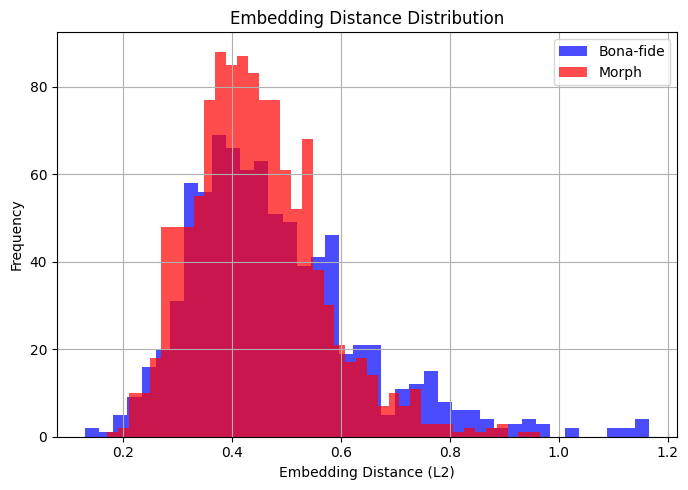

In [24]:
MODEL_NAME = "Baseline-2: FaceNet + Cosine Similarity FEI"

facenet_model = FaceNetEmbedder().to(device)

evaluate_and_plot(
    embed_model=facenet_model,
    dataloader=fei_test_loader,
    device=device,
    model_name=MODEL_NAME,
    dataset_name = "FEI"
)
